# 利用xgboost对 Rent Listing Inqueries 数据集 做分类

In [2]:
import numpy as np
import pandas as pd

# 正确率评价
from sklearn.metrics import accuracy_score
# Logloss评价
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

# 引入xgboost
from xgboost import XGBClassifier
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/randy/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 读入数据

In [3]:
# 读已经做完特征工程的数据集
train = pd.read_csv('./data/RentListingInquries_FE_train.csv')
test = pd.read_csv('./data/RentListingInquries_FE_test.csv')

In [3]:
# 看训练集前五行
train.head()

,bathrooms,bedrooms,price,price_bathrooms,price_bedrooms,room_diff,room_num,Year,Month,Day,...,walk,walls,war,washer,water,wheelchair,wifi,windows,work,interest_level
0,1.5,3,3000,1200.0,750.000000,-1.5,4.5,2016,6,24,...,0,0,0,0,0,0,0,0,0,1
1,1.0,2,5465,2732.5,1821.666667,-1.0,3.0,2016,6,12,...,0,0,0,0,0,0,0,0,0,2
2,1.0,1,2850,1425.0,1425.000000,0.0,2.0,2016,4,17,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1,3275,1637.5,1637.500000,0.0,2.0,2016,4,18,...,0,0,0,0,0,0,0,0,0,2
4,1.0,4,3350,1675.0,670.000000,-3.0,5.0,2016,4,28,...,0,0,1,0,0,0,0,0,0,2


In [4]:
# 看一下训练集的样本数
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49352 entries, 0 to 49351
Columns: 228 entries, bathrooms to interest_level
dtypes: float64(9), int64(219)
memory usage: 85.8 MB


In [5]:
# 看测试集前五行
test.head()

,bathrooms,bedrooms,price,price_bathrooms,price_bedrooms,room_diff,room_num,Year,Month,Day,...,virtual,walk,walls,war,washer,water,wheelchair,wifi,windows,work
0,1.0,1,2950,1475.000000,1475.000000,0.0,2.0,2016,6,11,...,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2850,1425.000000,950.000000,-1.0,3.0,2016,6,24,...,0,0,0,1,0,0,0,0,0,0
2,1.0,1,3758,1879.000000,1879.000000,0.0,2.0,2016,6,3,...,0,0,0,0,0,0,0,0,0,0
3,1.0,2,3300,1650.000000,1100.000000,-1.0,3.0,2016,6,11,...,0,0,0,0,0,0,1,0,0,0
4,2.0,2,4900,1633.333333,1633.333333,0.0,4.0,2016,4,12,...,0,0,0,1,0,0,0,0,0,0


In [6]:
# 看测试集样本数
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74659 entries, 0 to 74658
Columns: 227 entries, bathrooms to work
dtypes: float64(9), int64(218)
memory usage: 129.3 MB


## 初步建立模型

In [7]:
interest_level_counts = train.interest_level.value_counts()
interest_level_counts

2    34284
1    11229
0     3839
Name: interest_level, dtype: int64

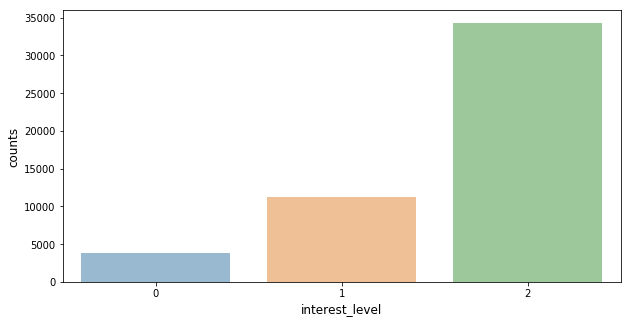

In [8]:
plt.figure(figsize=(10,5))
sns.barplot(x=interest_level_counts.index, y=interest_level_counts.values, alpha=0.5)
plt.ylabel('counts',fontsize=12)
plt.xlabel('interest_level',fontsize=12)
plt.show()

In [9]:
# 将数据集拆分
y_train = train.interest_level
X_train = train.drop("interest_level", axis=1)

## 先构建一个大致上合适的XGBOOST来训练

In [10]:
# 初始化一个KFOLD
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

In [11]:
# 初始化一个XGBClassifier
xgbc_default = XGBClassifier(
    learning_rate=0.1, # 学习速率，等同于xgb模型中的eta，默认0.3，通过减少每一步的权重，可以提高模型的鲁棒性
    n_estimators=1000, # num_boosting_rounds 数值大没关系，cv会自动返回合适的n_estimators 
    max_depth=5, # 最大树深度,默认6,这个值是用来避免过拟合的。max_depth越大，模型会学到更具体更局部的样本。
    min_child_weight=1, # 默认1,决定最小叶子节点样本权重和。这个参数用于避免过拟合。当它的值较大时，可以避免模型学习到局部的特殊样本。但是如果这个值过高，会导致欠拟合。这个参数需要使用CV来调整。
    gamma=0, # 默认0,在节点分裂时，只有分裂后损失函数的值下降了，才会分裂这个节点。Gamma指定了节点分裂所需的最小损失函数下降值。这个参数的值越大，算法越保守
    subsample=0.3, # 默认1典型值：0.5-1,这个参数控制对于每棵树，随机采样的比例。减小这个参数的值，算法会更加保守，避免过拟合。但是，如果这个值设置得过小，它可能会导致欠拟合。
    colsample_bytree=0.8, #默认1典型0.5-1,用来控制每棵随机采样的列数的占比(每一列是一个特征)
    colsample_bylevel=0.7, #默认1用来控制树的每一级的每一次分裂，对列数的采样的占比
    objective='multi:softprob', #学习目标参数,这个参数定义需要被最小化的损失函数
    seed=3 # 默认0,随机数的种子,设置它可以复现随机数据的结果，也可以用于调整参数
)

In [19]:
# 交叉验证
def model_fit(alg, X_train, y_train, useTrainCV=True, cv_folds=5, early_stopping_rounds=10):
    xgb_param = alg.get_xgb_params()
    xgb_param['num_class'] = 3 # 如果是多分类问题，需要设置分类数，此数据集按照上面的分析是3分类问题
    
    # 用xgb自带的cv需先整合数据集
    xgtrain = xgb.DMatrix(X_train, label = y_train)
    
    # 初始化cv
    cv_result = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
             metrics='mlogloss', early_stopping_rounds=early_stopping_rounds)
    
    # 将cv后的数据存入csv中
    cv_result.to_csv('1_nestimators.csv', index_label = 'n_estimators')
    
    # 最佳参数n_estimators
    n_estimators = cv_result.shape[0]
    
    # 采用交叉验证得到的最佳参数n_estimators，训练模型
    alg.set_params(n_estimators = n_estimators)
    alg.fit(X_train, y_train, eval_metric='mlogloss')

In [20]:
model_fit(xgbc_default, X_train, y_train)

In [6]:
cvresult = pd.DataFrame.from_csv('1_nestimators.csv')
cvresult.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272 entries, 0 to 271
Data columns (total 4 columns):
test-mlogloss-mean     272 non-null float64
test-mlogloss-std      272 non-null float64
train-mlogloss-mean    272 non-null float64
train-mlogloss-std     272 non-null float64
dtypes: float64(4)
memory usage: 10.6 KB


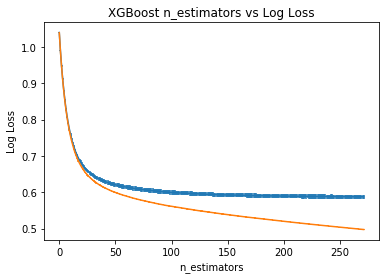

In [7]:
# plot
test_means = cvresult['test-mlogloss-mean']
test_stds = cvresult['test-mlogloss-std'] 
        
train_means = cvresult['train-mlogloss-mean']
train_stds = cvresult['train-mlogloss-std'] 

x_axis = range(0, cvresult.shape[0])

# 误差棒图
plt.errorbar(x_axis, test_means, yerr=test_stds ,label='Test')
plt.errorbar(x_axis, train_means, yerr=train_stds ,label='Train')
plt.title("XGBoost n_estimators vs Log Loss")
plt.xlabel( 'n_estimators' )
plt.ylabel( 'Log Loss' )
plt.savefig( 'n_estimators_1.png' )

plt.show()

## 再看下测试和训练集差别较大的部分

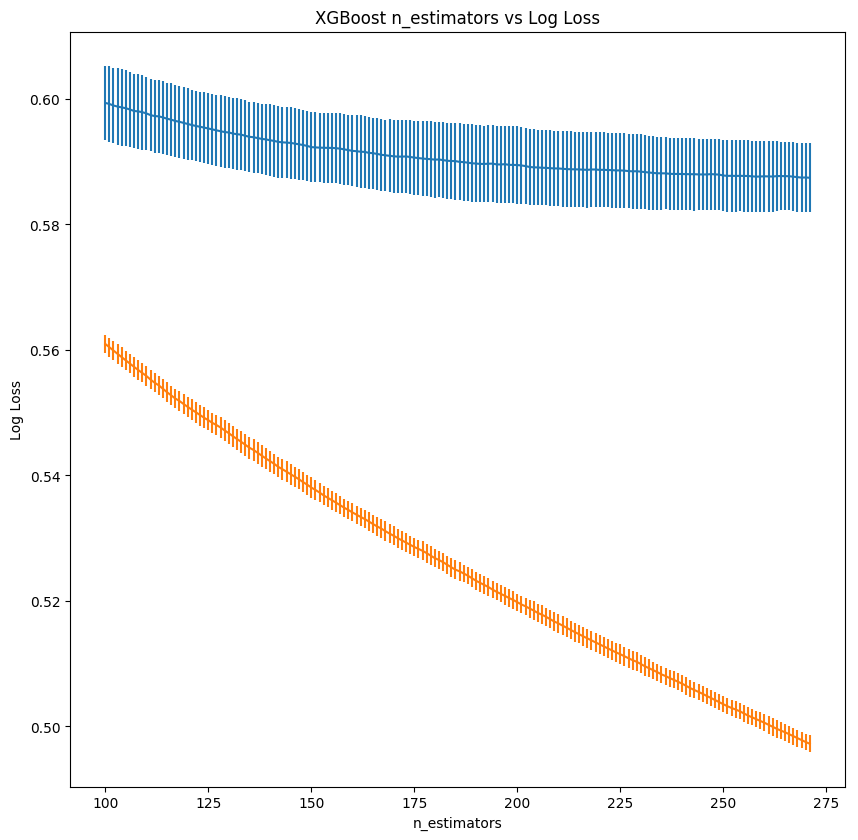

In [9]:
cvresult_detail = cvresult.iloc[100:]

test_means = cvresult_detail['test-mlogloss-mean']
test_stds = cvresult_detail['test-mlogloss-std']

train_means = cvresult_detail['train-mlogloss-mean']
train_stds = cvresult_detail['train-mlogloss-std']

x_axis_detail = range(100, cvresult_detail.shape[0]+100)

fig = plt.figure(figsize=(10,10), dpi=100)
plt.errorbar(x_axis_detail, test_means, yerr=test_stds, label="Test")
plt.errorbar(x_axis_detail, train_means, yerr=train_stds, label="Train")
plt.title("XGBoost n_estimators vs Log Loss")
plt.xlabel( 'n_estimators' )
plt.ylabel( 'Log Loss' )
plt.savefig( 'n_estimators_1_detail.png' )

## 我们将调参数据记录下，在新的文件Regression_2_RentListingInqueries中尝试新一轮调参